In [27]:
%run classes.ipynb
# Training cell
import numpy as np
from sklearn.model_selection import train_test_split

emptyRatioA = 47
emptyRatioB = 30
emptyRatioC = 24
objectwidth = 83
objectheight = 122

odtype = 'moran'
neighbourhoodDistance = 5
porositythreshold = 0.5
neighbourhoodZ = 1
windowSize = 75
windowAdvance = 25
noOfBins = 20
n_neighbors = 3
test_size = 0.4
hsegments = [0,26,50,74,98,122]
mask = np.zeros((objectwidth, objectheight))
bend = 225

X_train = readRawTreeImages()
labels = getLabels(porositythreshold)
Y_train = np.copy(labels)

# Todo: Uncomment this line

mask = makeMask(X_train, emptyRatioA)

bgr = backgroundRemover(mask)
ab = blockAccumulator(windowSize, windowAdvance)
oc1 = outlierCalculator(odtype, neighbourhoodDistance, neighbourhoodZ)
# a1 = accumulator(windowSize, windowOffset)

# Hur modellerar vi det här? Objekt med olika höjd blir kaos, eller? Skulle kunna skicka tomma bilder när de är slut. 

allTrainingHists = []

def makesegments(image, hsegments):
    segments = []
    for obimg in image:
        for i in range(len(hsegments)-1):
            segments.append(obimg[hsegments[i]:hsegments[i+1],:])
    return segments

trainObjects1 = np.moveaxis(X_train, 1, 0)

allOcvals = []
allPresValues = []
i = 0
for image in trainObjects1:
    # Ta bilden, omvandla till en array av bilder (en bild per obj)
    # Vilken struktur behöver preprocess? Lista med numpy array
    # image är 26x122x83
    # segments ska vara (26*5)x122x83
    noback = bgr.removeBackground(image)
    segments = makesegments(noback, hsegments)
    segmentblocks = ab.next(segments)
    if(segmentblocks is False):
        continue
    # plt.hist(trainoutliers[0][1].flatten(), bins=bincount, range=(minval, maxval))
    ocvals = oc1.calculate(segmentblocks)
    allOcvals.append(ocvals)
    i+=1
    # if(i == 0 or i == 1 or i == 2):
    #     plt.imshow(pres[0])
    #     plt.figure()
    #     plt.hist(pres[0].flatten())
    #     plt.yscale('log')
    #     plt.figure()
    # ocVals: List[layers][objects][matrix]

acount = len(trainObjects1)
oc1.reset()
ab.reset()

X_train2 = readRawHouseImages()
trainObjects2 = np.moveaxis(X_train2, 1, 0)
maskB = makeMaskB(X_train2, emptyRatioB)
bgrb = backgroundRemover(maskB)
for image in trainObjects2:
    noback = bgrb.removeBackground(image)
    segments = noback
    segmentblocks = ab.next(segments)
    if(segmentblocks is False):
        continue
    ocvals = oc1.calculate(segmentblocks)
    allOcvals.append(ocvals)

ocmin = np.nanmin(np.concatenate([np.concatenate([o.flatten() for o in oo]) for oo in allOcvals]))
ocmax = np.nanmax(np.concatenate([np.concatenate([o.flatten() for o in oo]) for oo in allOcvals]))
e1 = encoder(noOfBins, ocmin, ocmax)

for ocvals in allOcvals:
    if len(ocvals) > 0:
        # Print a chart here
        # tar encode en lista av 3d?
        hists = e1.encode(ocvals)
        for acc in hists:
            allTrainingHists.append(acc)


Note: you may need to restart the kernel to use updated packages.


In [28]:
labelRanges = [(i, i+windowSize) for i in range(0, bend-windowSize+1, windowAdvance)]
ytrainb = [getLabelsB(objIndex, 0.5, start, end) for (start, end) in labelRanges for objIndex in range(1,29)]
repetitionsA = (len(allTrainingHists)-len(ytrainb)) // len(Y_train)
knn = neighbors.KNeighborsClassifier(n_neighbors, weights="uniform", n_jobs=-1)
scaler = StandardScaler()
clf = Pipeline([('scaler', scaler), ('classifier', knn)])
ytrain2 = np.tile(Y_train.astype('int'), [np.int32(repetitionsA)])
ytrainboth = np.concatenate([ytrain2, ytrainb])
clf.fit(allTrainingHists, ytrainboth)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_jobs=-1, n_neighbors=3))])

In [29]:
np.shape(allTrainingHists)

(896, 20)

In [30]:
# xtrain_real = allTrainingHists
# ytrain_real = ytrainboth
# xtest_real = testx
# ytest_real = y_test

Note: you may need to restart the kernel to use updated packages.
0.8462301587301587


Text(0.5, 0, 'Window start layer')

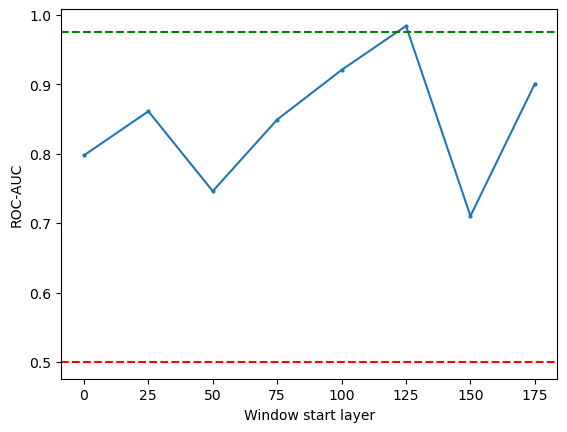

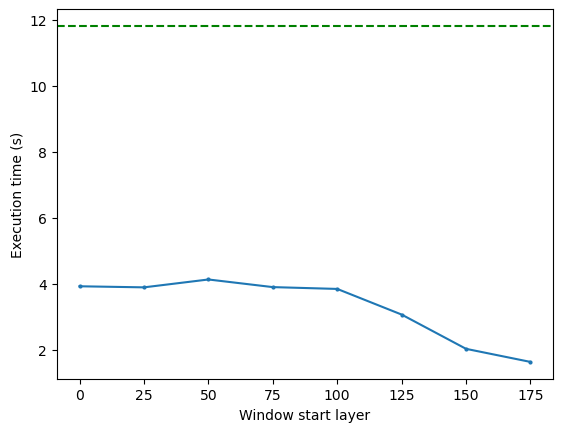

In [42]:
%run classes.ipynb
# Testing cell
from sklearn.metrics import f1_score, roc_auc_score
import time
twindowSize = windowSize
twindowAdvance = windowAdvance
twindowSize = 50
twindowAdvance = 25

oc1.reset()
ab = blockAccumulator(twindowSize, twindowAdvance)

X_test = readCSet()
# X_test = readRawHouseImages()
testObjects = np.moveaxis(X_test, 1, 0)
maskB = makeMaskB(X_test, emptyRatioB)
bgrb = backgroundRemover(maskB)

testx = []
predictions = []
times = []
letsPrint = False
i = 0
for image in testObjects:
    # Start of timing
    i += 1
    start_time = time.time()
    noback = bgrb.removeBackground(image)
    # segments = makesegments(noback, hsegments)
    segments = noback
    segmentblocks = ab.next(segments)
    if(segmentblocks is False):
        continue
    ocvals = oc1.calculate(segmentblocks)
    hists = e1.encode(ocvals)
    pred = clf.predict_proba(hists)[:,1]
    times.append(time.time() - start_time)
    # End of timing
    testx.append(hists)
    predictions.append(pred)
    # %run classes.ipynb

# investigate accuracy etc here. Potentially batch it based on layer
labelRanges = [(i, i+twindowSize) for i in range(0, bend-twindowSize+1, twindowAdvance)]
y_test = [getLabelsC(objIndex, 0.5, start, end) for (start, end) in labelRanges for objIndex in range(1,26)]
# y_test = [getLabelsB(objIndex, 0.5, start, end) for (start, end) in labelRanges for objIndex in range(1,29)]
ysvalue = []
for index, o in enumerate(predictions):
    ysvalue.append(roc_auc_score(y_test[index*25:(index+1)*25], o))
plt.plot([s for (s, e) in labelRanges], ysvalue, 'o-', markersize=2)
print(np.mean(ysvalue))
plt.ylabel("ROC-AUC")
plt.xlabel("Window start layer")
plt.axline((0, 0.975), (1, 0.975), color='g', linestyle='--')
plt.axline((0, 0.5), (1, 0.5), color='r', linestyle='--')
plt.figure()
plt.plot([s for (s, e) in labelRanges], times, 'o-', markersize=2)
plt.axline((0, 11.82), (1, 11.82), color='g', linestyle='--')
# plt.axline((0, 10.75), (1, 10.75), color='g', linestyle='--')
plt.ylabel("Execution time (s)")
plt.xlabel("Window start layer")

In [33]:
y_test = [getLabelsC(objIndex, 0.5, start, end) for (start, end) in labelRanges for objIndex in range(1,26)]

xtrain_real =  np.array(allTrainingHists)
ytrain_real =  np.array(ytrainboth)
(x,y,z) = np.shape(testx)
xtest_real = np.reshape(testx, ((x*y,z)))
ytest_real = np.array(y_test)


print(np.shape(xtrain_real))
print(np.shape(ytrain_real))
print(np.shape(xtest_real))
print(np.shape(ytest_real))

(896, 20)
(896,)
(175, 20)
(175,)


0.28
0.28
[(0, 75), (25, 100), (50, 125), (75, 150), (100, 175), (125, 200), (150, 225)]


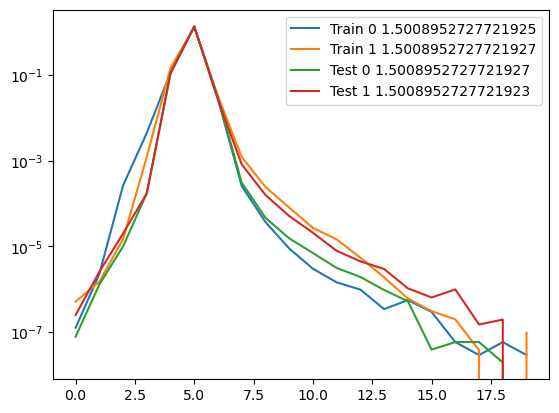

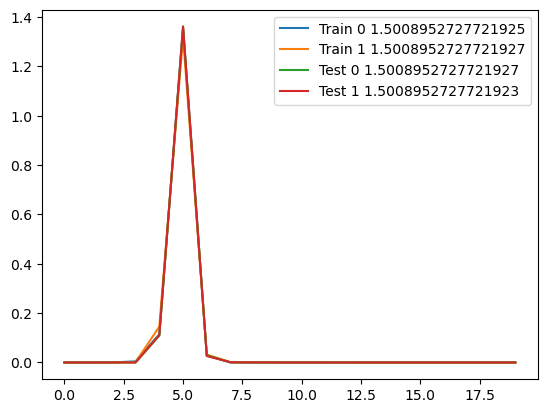

In [34]:
# Draw the average histogram for each label in the training set
train0 = np.mean(xtrain_real[ytrain_real == 0], axis=0)
train1 = np.mean(xtrain_real[ytrain_real == 1], axis=0)
# Draw the average histogram for each label in the testing set
test0 = np.mean(xtest_real[ytest_real == 0], axis=0)
test1 = np.mean(xtest_real[ytest_real == 1], axis=0)
plt.plot(range(0, len(train0)), train0, label="Train 0 " + str(np.sum(train0)))
plt.plot(range(0, len(train1)), train1, label="Train 1 " + str(np.sum(train1)))
plt.plot(range(0, len(test0)), test0, label="Test 0 " + str(np.sum(test0)))
plt.plot(range(0, len(test1)), test1, label="Test 1 " + str(np.sum(test1)))
plt.legend()
plt.yscale('log')
plt.figure()
print(np.average(ytest_real))
print(np.average(y_test))
print(labelRanges)
plt.plot(range(0, len(train0)), train0, label="Train 0 " + str(np.sum(train0)))
plt.plot(range(0, len(train1)), train1, label="Train 1 " + str(np.sum(train1)))
plt.plot(range(0, len(test0)), test0, label="Test 0 " + str(np.sum(test0)))
plt.plot(range(0, len(test1)), test1, label="Test 1 " + str(np.sum(test1)))
plt.legend()

In [35]:
len(y_test)

175

Note: you may need to restart the kernel to use updated packages.


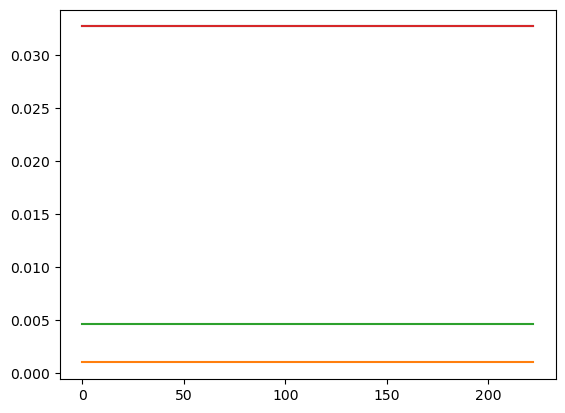

In [36]:
# Plot porosity over time for different objects. Ho
%run classes.ipynb
windowSize = 20
xs = range(0,223)
x1 = []
x2 = []
x3 = []
x4 = []
for i in xs:
    x1.append(getCporosities(0, i, i+windowSize))
    x2.append(getCporosities(1, i, i+windowSize))
    x3.append(getCporosities(24, i, i+windowSize))
    x4.append(getCporosities(25, i, i+windowSize))
plt.plot(xs, x1)
plt.plot(xs, x2)
plt.plot(xs, x3)
plt.plot(xs, x4)

In [37]:
%run classes.ipynb
getCporosities(25, 224, 224+windowSize)
porositymat = scipy.io.loadmat('../porosity.mat', simplify_cells=True)
porosity = porositymat['porosity'][1]
print(porosity[24][210:225])

Note: you may need to restart the kernel to use updated packages.
[0.00396079 0.00759396 0.02943831]


In [38]:

print(np.mean(ytrain2))
print(np.mean(ytrainb))
print(np.mean(y_test))
print(np.mean(predictions))

0.22857142857142856
0.24489795918367346
0.28
0.28


In [39]:
%run classes.ipynb
trees = readRawTreeImages()
houses = readRawHouseImages()
newHouses = readCSet()

Note: you may need to restart the kernel to use updated packages.


<Figure size 640x480 with 0 Axes>

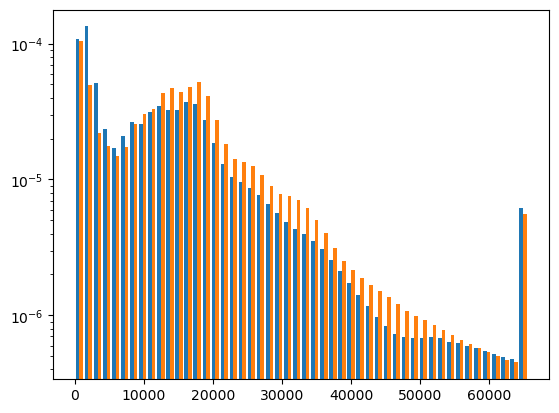

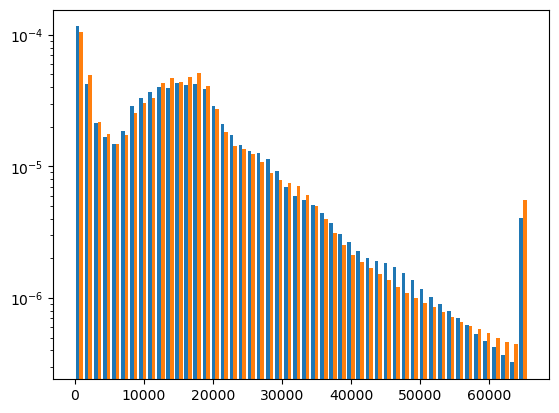

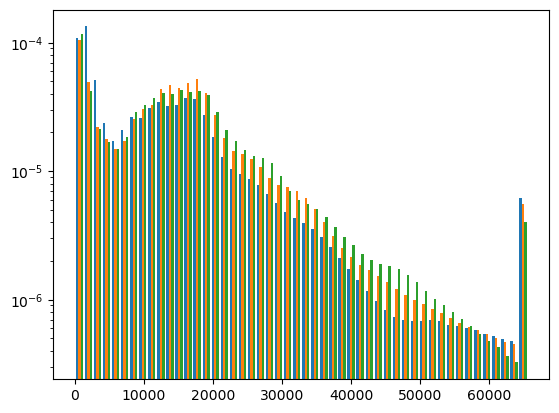

<Figure size 640x480 with 0 Axes>

In [40]:
threshold = 0.5
treelabels = getLabels(porositythreshold)
houselabels = [getLabelsB(x, porositythreshold, 0, 255) for x in range(1,29)]
newhouselabels = [getLabelsC(x, porositythreshold, 0, 255) for x in range(1,26)]

plt.hist([trees.flatten(), houses.flatten()], bins=50, density=True)
plt.yscale('log')
plt.figure()
plt.hist([newHouses.flatten(), houses.flatten()], bins=50, density=True)
plt.yscale('log')
plt.figure()
plt.hist([trees.flatten(), houses.flatten(), newHouses.flatten()], bins=50, density=True)
plt.yscale('log')
plt.figure()

In [41]:
threshold = 0.5
treelabels = getLabels(porositythreshold)
houselabels = [getLabelsB(x, porositythreshold, 0, 255) for x in range(1,29)]
newhouselabels = [getLabelsC(x, porositythreshold, 0, 255) for x in range(1,26)]

plt.hist([trees[treelabels == 1].flatten(), houses[houselabels == 1].flatten()], bins=50, density=True)
plt.yscale('log')
plt.figure()
plt.hist([houses[houselabels == 0].flatten(), houses[houselabels == 1].flatten()], bins=50, density=True)
plt.yscale('log')
plt.figure()
plt.hist([newHouses[newhouselabels == 0].flatten(), newHouses[newhouselabels == 1].flatten()], bins=50, density=True)
plt.yscale('log')
plt.figure()
# plt.hist([newHouses.flatten(), houses.flatten()], bins=50, density=True)
# plt.yscale('log')
# plt.figure()
# plt.hist([trees.flatten(), houses.flatten(), newHouses.flatten()], bins=50, density=True)
# plt.yscale('log')
# plt.figure()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 28 but corresponding boolean dimension is 140

In [ ]:
newHouses = readCSet()

Note: you may need to restart the kernel to use updated packages.


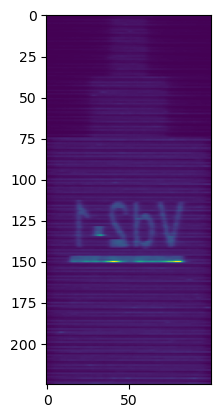

In [ ]:
%run classes.ipynb
# 2 är 3 och 3 är 1 och 1 är 1. 
# newHouses = readCSet()
# newhouselabels = [getLabelsC(x, porositythreshold, 0, 255) for x in range(1,26)]
new1 = newHouses[0]
new2 = newHouses[2]
plt.imshow(np.flip(new1[:,99,:]))

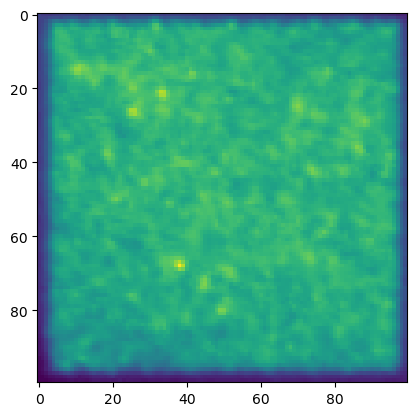

In [ ]:
newhouselabels = [getLabelsC(x, porositythreshold, 0, 255) for x in range(1,26)]
new1 = newHouses[0]
new2 = newHouses[2]
plt.imshow(newHouses[4,187])